In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as ss
import matplotlib.pyplot as plt
import os
from bmtool.util.util import load_nodes_from_paths
from scipy.ndimage import gaussian_filter

from analysis import plot, utils, process, metric # imoporting analysis module enables import from model folder
from build_input import get_populations, input_pairs_from_file

%matplotlib inline

TRIAL_NAME = "ramp_a0_t1.0_LONG_div"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)
OUTPUT_PATH = "analysis_results"

pop_color = plot.pop_color
pop_names = plot.pop_names

### Load data

In [2]:
stim_type, paths, stim_info, config_hp = utils.get_trial_info(TRIAL_PATH)
stimulus_type, isbaseline, isstandard = stim_type
INPUT_PATH, NODE_FILES, SPIKE_FILE = paths
t_stop, stim_setting, stim_params = stim_info

t_start = stim_params['t_start']
on_time, off_time = stim_params['on_time'], stim_params['off_time']

In [3]:
network_name = 'cortex'

node_df = load_nodes_from_paths(NODE_FILES)[network_name]
pop_ids = get_populations(node_df, pop_names, only_id=True)

spikes_df = utils.load_spikes_to_df(SPIKE_FILE, network_name)

### Get population spike rate

In [4]:
# Processing parameters
fs = 400.  # Hz. sampling frequency
time = np.linspace(0, 1000 * t_stop, int(t_stop * fs), endpoint=False)

filt_order = 4  # filter order
filt_cutoff = 8.  # Hz. filter cutoff frequency
sos = ss.butter(N=filt_order, Wn=filt_cutoff, fs=fs, output='sos')
freq_range = (5.0, 70.)  # Hz. Scalogram frequency range

In [5]:
# node ids in assemblies
_, Assembly_ids = input_pairs_from_file(os.path.join(INPUT_PATH, 'Assembly_ids.csv'))
n_assy = len(Assembly_ids)
assy_ids = {a: ids for a, ids in enumerate(Assembly_ids)}
assy_names = {a: f'assembly {a:d}' for a in assy_ids}

# get assembly groups if obtained from intrinsic assemblies
div_ids_file = os.path.join(INPUT_PATH, 'Division_ids.csv')
isdivision = os.path.isfile(div_ids_file)
if isdivision:
    div_id = pd.read_csv(div_ids_file, index_col='division_id')['assembly_id']
    assy_div = {v: div_id[div_id == v].index.tolist() for v in div_id.unique()}
    assy_ids_disp = [a for ids in assy_div.values() for a in ids]
else:
    assy_ids_disp = list(assy_ids)
assy_names_disp = [assy_names[a] for a in assy_ids_disp]

# indices of assemblies being stimulated
assy_stim = list(range(n_assy)) if isstandard \
    else stim_setting['setting']['assembly_index']

# collect assemblies not stimuluted
rest_assy = assy_ids.keys() - set(assy_stim)
if rest_assy:
    def move_to_rest(assy, idx, name):
        global rest_assy
        assy_ids[idx] = sorted(n for a in assy for n in assy_ids.pop(a))
        assy_names[idx] = name  # idx value has no meaning, just an index
        rest_assy -= assy
    if isdivision:
        for i in div_id[assy_stim].unique():  # intrinsic assemblies being stimulated
            # division assemblies in the same intrinsic assembly but not stimulated
            move_to_rest(set(assy_div[i]) & rest_assy, -1 -i, f'rest in {i}')
    move_to_rest(rest_assy, -n_assy, 'rest')  # remaining assemblies not stimulated
rest_assy_ids = [a for a in assy_ids if a < 0]  # rest assemblies to show

# group names and ids
PN_pop_names = ['CP', 'CS']
ITN_pop_names = ['FSI', 'LTS']
group_ids = {(a, p): sorted(set(pop_ids[p]) & set(ids))
             for a, ids in assy_ids.items() for p in PN_pop_names}
group_names = {(a, p): p + ' ' + assy_names[a] for a in assy_ids for p in PN_pop_names}

In [6]:
grp_rspk = process.group_spike_rate_to_xarray(spikes_df, time, group_ids)
pop_rspk = process.group_spike_rate_to_xarray(spikes_df, time,
    {p: pop_ids[p] for p in ITN_pop_names}, group_dims='population')  # include only ITN
for da in [grp_rspk, pop_rspk]:
    axis = da.spike_rate.dims.index('time')
    # low-pass filter
    da.update(dict(LP_fiilt_spike_rate=xr.zeros_like(da.spike_rate)))
    da.LP_fiilt_spike_rate[:] = ss.sosfilt(sos, da.spike_rate, axis=axis)
    da.attrs.update({'filt_order': filt_order, 'filt_cutoff': filt_cutoff})
    # scalogram
    coords = {k: v for k, v in da.spike_rate.coords.items() if k != 'time'}
    da.update(plot.cwt_spectrogram_xarray(da.spike_rate, da.fs, axis = axis,
        time=da.spike_rate.coords['time'], channel_coords=coords, freq_range=freq_range))

display(grp_rspk)
display(pop_rspk)

<xarray.Dataset>
Dimensions:                      (assembly: 3, population: 2, time: 5800, frequency: 22)
Coordinates:
  * time                         (time) float64 1.25 3.75 ... 1.45e+04 1.45e+04
  * assembly                     (assembly) int64 -9 -1 0
  * population                   (population) object 'CP' 'CS'
  * frequency                    (frequency) float64 5.568 6.25 ... 56.12 63.0
Data variables:
    spike_rate                   (assembly, population, time) float64 0.0 ......
    population_number            (assembly, population) int32 2676 2657 ... 450
    LP_fiilt_spike_rate          (assembly, population, time) float64 0.0 ......
    PSD                          (assembly, population, frequency, time) float64 ...
    cone_of_influence_frequency  (time) float64 1.146e+03 381.8 ... 1.146e+03
Attributes:
    fs:           400.0
    filt_order:   4
    filt_cutoff:  8.0

<xarray.Dataset>
Dimensions:                      (population: 2, time: 5800, frequency: 22)
Coordinates:
  * population                   (population) <U3 'FSI' 'LTS'
  * time                         (time) float64 1.25 3.75 ... 1.45e+04 1.45e+04
  * frequency                    (frequency) float64 5.568 6.25 ... 56.12 63.0
Data variables:
    spike_rate                   (population, time) float64 0.0 0.0 ... 6.5 2.0
    population_number            (population) int32 1200 800
    LP_fiilt_spike_rate          (population, time) float64 0.0 0.0 ... 4.274
    PSD                          (population, frequency, time) float64 8.96 ....
    cone_of_influence_frequency  (time) float64 1.146e+03 381.8 ... 1.146e+03
Attributes:
    fs:           400.0
    filt_order:   4
    filt_cutoff:  8.0

### Get oscillations

In [7]:
wave_lines = {'gamma': ':', 'beta': '--'}
wave_color = {'gamma': 'tab:red', 'beta': 'tab:purple'}

wave_kwargs = {
    'filter': dict(
        waves = {'gamma': (30.0, 44.0), 'beta': (14.5, 23.5)},
        transform = process.wave_hilbert,
        filt_order = 4
    ),
    'wavelet': dict(
        waves = {'gamma': 37.0, 'beta': 19.0},
        transform = process.wave_cwt,
        bandwidth = 2.0  # time band (inverse to frequency band), sigma of the gaussian envelope for frequency 1.0
    )
}

In [8]:
method = 'wavelet'
grp_waves = process.get_waves(grp_rspk.spike_rate, fs=grp_rspk.fs, **wave_kwargs[method])
pop_waves = process.get_waves(pop_rspk.spike_rate, fs=pop_rspk.fs, **wave_kwargs[method])
waves = grp_waves.wave.values

### Analyze population spike rate

In [9]:
win_extend = 0.4  # extend window by 0.3 sec after stimulus off
windows = 1000. * process.get_stim_windows(on_time, off_time, t_start, t_stop,
                                           win_extend=win_extend)

# assemblies to be plotted in each unique stimulus cycle {unique cycle id: assembly ids}
sel_cyc = None
if stimulus_type == 'long':
    sel_assy = [0, 1, 4]
    sel_cyc = sel_assy
    cyc_to_assy = {i: [assy_stim[j] for j in sel_assy] for i in range(len(assy_stim))}
elif stimulus_type == 'short':
    sel_assy = [0, 1, 4]
    cyc_to_assy = {0: [assy_stim[j] for j in sel_assy]}
else:
    cyc_to_assy = {0: assy_stim}

max_unique_cyc = 2  # maximum number of unique cycles to show
# unique cycle ids to show
if sel_cyc is not None:
    show_unique_cyc = [i for i in sel_cyc if i in cyc_to_assy]
else:
    show_unique_cyc = list(cyc_to_assy.keys())[:max_unique_cyc]
show_assy_ids = {i: cyc_to_assy[i] + rest_assy_ids for i in show_unique_cyc}

# indices of windows with the same stimulus cycles {unique cycle id: cycle numbers}
n_unique_cycle = len(cyc_to_assy)
win_grp_idx = {i: np.arange(i, windows.shape[0], n_unique_cycle)
               for i in range(n_unique_cycle)}

In [10]:
_, grp_rspk_cyc_onff, grp_rspk_cyc_std = process.get_windowed_data(
    grp_rspk.spike_rate, windows, win_grp_idx)
_, _, grp_rspk_cyc_avg = process.get_windowed_data(
    grp_rspk.LP_fiilt_spike_rate, windows, win_grp_idx)
_, _, grp_waves_avg = process.get_windowed_data(grp_waves, windows, win_grp_idx)
_, _, grp_psd_cyc_avg = process.get_windowed_data(grp_rspk.PSD, windows, win_grp_idx)

_, pop_rspk_cyc_onff, pop_rspk_cyc_std = process.get_windowed_data(
    pop_rspk.spike_rate, windows, win_grp_idx)
_, _, pop_rspk_cyc_avg = process.get_windowed_data(
    pop_rspk.LP_fiilt_spike_rate, windows, win_grp_idx)
_, _, pop_waves_avg = process.get_windowed_data(pop_waves, windows, win_grp_idx)
_, _, pop_psd_cyc_avg = process.get_windowed_data(pop_rspk.PSD, windows, win_grp_idx)

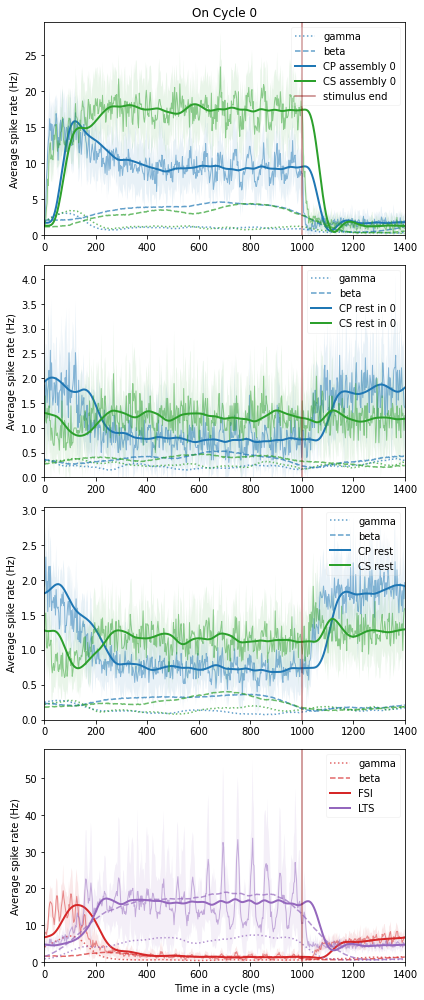

In [11]:
figsize = (6, 3.5)
show_trials = False
show_raw = True
show_amp = True

show_off = int(n_unique_cycle > 1) + 1

def plot_rspk(ax, da, p, label, shaded_std=False, **kwargs):
    """Plot spike rate mean and std in shaded region"""
    x = da.sel(population=p)
    if shaded_std:
        ax.fill_between(t_cyc, x.mean_ - x.std_, x.mean_ + x.std_,
                        facecolor=pop_color[p], edgecolor='none', alpha=0.1)
    ax.plot(t_cyc, x.mean_, color=pop_color[p],
            label=label, **kwargs)

def plot_trials(ax, da):
    for i in da.coords['cycle']:
        ax.plot(t_cyc, da.sel(cycle=i), color=pop_color[p], linewidth=1, alpha=0.3)

def plot_amp(ax, da, p, label=False):
    da = da.mean_.sel(population=p)
    line_props = dict(color=pop_color[p], linewidth=1.5, alpha=0.7)
    for w in waves:
        ax.plot(t_cyc, da.sel(wave=w), linestyle=wave_lines[w],
                label=w if label else None, **line_props)

def extract_data(data, onff, unique_cycle, assembly=None):
    sel = {'unique_cycle': unique_cycle}
    if assembly is not None:
        sel['assembly'] = assembly
    return data[onff].sel(**sel)

t_cyc = grp_rspk_cyc_avg[0].time.values
grp_data = [grp_rspk_cyc_avg, grp_rspk_cyc_std, grp_waves_avg]
pop_data = [pop_rspk_cyc_avg, pop_rspk_cyc_std, pop_waves_avg]

for i, show_assy in show_assy_ids.items():
    n_rows = len(show_assy) + 1
    _, axs = plt.subplots(n_rows, show_off, squeeze=False,
                          figsize=(figsize[0] * show_off, figsize[1] * n_rows))
    for j in range(show_off):
        for a, ax in zip(show_assy, axs[:-1, j]):
            da, da_std, da_wv = [extract_data(d, j, i, a) for d in grp_data]
            for k, p in enumerate(PN_pop_names):
                if show_trials:
                    plot_trials(ax, grp_rspk_cyc_onff[j][i].sel(assembly=a, population=p))
                if show_raw:
                    plot_rspk(ax, da_std, p, None, shaded_std=True, linewidth=1, alpha=0.5)
                if show_amp:
                    plot_amp(ax, da_wv, p, label=not k)
                plot_rspk(ax, da, p, group_names[(a, p)], linewidth=2)
        da, da_std, da_wv = [extract_data(d, j, i) for d in pop_data]
        ax = axs[-1, j]
        for k, p in enumerate(ITN_pop_names):
            if show_trials:
                plot_trials(ax, pop_rspk_cyc_onff[j][i].sel(population=p))
            if show_raw:
                plot_rspk(ax, da_std, p, None, shaded_std=True, linewidth=1, alpha=0.5)
            if show_amp:
                plot_amp(ax, da_wv, p, label=not k)
            plot_rspk(ax, da, p, p, linewidth=2)
    for j, ax in enumerate(axs.ravel()):
        ax.axvline(on_time * 1000, color='darkred', alpha=0.5,
                   label=None if j else 'stimulus end')
        ax.set_xlim(0, 1000 * (on_time + win_extend))
        ax.set_ylim(bottom=0)
    for ax in axs[:, 0]:
        ax.set_ylabel('Average spike rate (Hz)')
        ax.legend(loc='upper right', framealpha=0.2)
    for j, ax in enumerate(axs[0, :]):
        ax.set_title(('Off' if j else 'On') + f' Cycle {i:d}')
    for ax in axs[-1, :]:
        ax.set_xlabel('Time in a cycle (ms)')
    plt.tight_layout()
plt.show()

### Scalogram

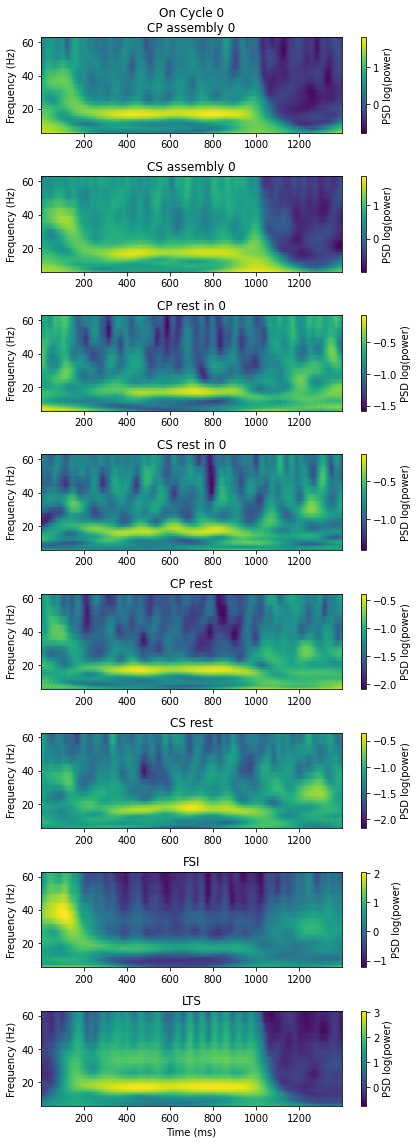

In [12]:
figsize = (6, 2)

def iterate_grp_psd(unique_cycle, onff, show_assy):
    for a in show_assy:
        for p in PN_pop_names:
            da = grp_psd_cyc_avg[onff].sel(unique_cycle=unique_cycle, assembly=a, population=p)
            yield da.mean_.to_dataset(name='PSD'), group_names[(a, p)]
    for p in ITN_pop_names:
        da = pop_psd_cyc_avg[onff].sel(unique_cycle=unique_cycle, population=p)
        yield da.mean_.to_dataset(name='PSD'), p

for i, show_assy in show_assy_ids.items():
    n_rows = len(show_assy) * len(PN_pop_names) + len(ITN_pop_names)
    _, axs = plt.subplots(n_rows, show_off, squeeze=False,
                          figsize=(figsize[0] * show_off, figsize[1] * n_rows))
    for j in range(show_off):
        for k, (da, grp_name) in enumerate(iterate_grp_psd(i, j, show_assy)):
            ax = axs[k, j]
            _ = plot.plot_spectrogram(da, log_power=True, ax=ax)
            ax.set_title(('' if k else ('Off' if j else 'On') + f' Cycle {i:d}\n') + grp_name)
            ax.set_xlabel('')
        ax.set_xlabel('Time (ms)')
    plt.tight_layout()
plt.show()

### Entrainment

#### PNs

In [13]:
PN_phase = process.get_waves(process.combine_spike_rate(
    grp_rspk, dim=['assembly', 'population']).spike_rate,
    fs=grp_rspk.fs, component='pha', **wave_kwargs[method])

assy_tspk = {a: process.get_windowed_spikes(spikes_df, windows, ids) for a, ids in assy_ids.items()}
assy_plv = {w: {a: metric.phase_locking_value(
    process.get_spike_phase(PN_phase.sel(wave=w), PN_phase.time, t))
    for a, t in assy_tspk.items()} for w in waves}

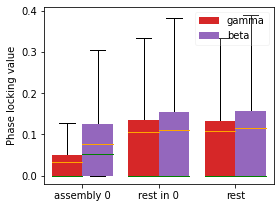

In [14]:
bargap = 0.2
bw = (1 - bargap) / waves.size
box_kwargs = dict(widths=bw, showmeans=True, meanline=True, patch_artist=True,
    showfliers=False, showcaps=True, whiskerprops={'color':'k'}, 
    meanprops=dict(linestyle='-', color='orange'),
    medianprops=dict(linestyle='-', color='g'))
pos = np.arange(len(assy_ids))
labels = [assy_names[a] for a in assy_ids]

figsize = (1, 3)
_, ax = plt.subplots(figsize=(figsize[0] * (len(assy_ids) + 1), figsize[1]))
bp = {}
for i, (w, plv) in enumerate(assy_plv.items()):
    b = ax.boxplot(plv.values(), positions=pos + (i + .5) * bw, **box_kwargs)['boxes']
    for patch in b:
        patch.set_facecolor(wave_color[w])
        patch.set_edgecolor('none')
    bp[w] = b[0]
ax.set_xticks(pos + (1 - bargap) / 2)
ax.set_xticklabels(labels)
ax.set_xlim(-bargap / 2, len(assy_ids) - bargap / 2)
ax.set_ylabel('Phase locking value')
ax.legend(bp.values(), bp.keys(), loc='upper right', framealpha=0.2)
plt.tight_layout()
plt.show()

#### ITNs

In [15]:
ITN_phase = process.get_waves(pop_rspk.spike_rate,
    fs=pop_rspk.fs, component='pha', **wave_kwargs[method])

ITN_tspk = {p: process.get_windowed_spikes(spikes_df, windows, pop_ids[p]) for p in ITN_pop_names}
ITN_plv = {w: {p: metric.phase_locking_value(
    process.get_spike_phase(ITN_phase.sel(wave=w, population=p), ITN_phase.time, t))
    for p, t in ITN_tspk.items()} for w in waves}

In [16]:
plv_df = {}
for w, plv in assy_plv.items():
    plv_df[w, 'PN'] = np.concatenate(list(plv.values()))
for w, plv in ITN_plv.items():
    for p, v in plv.items():
        plv_df[w, p] = v
plv_df = {wp: dict(median=np.median(plv), mean=plv.mean(), stdev=plv.std()) for wp, plv in plv_df.items()}
plv_df = pd.DataFrame.from_dict(plv_df, orient='index')
plv_df = plv_df.loc[pd.MultiIndex.from_product((waves, ['PN'] + ITN_pop_names))]
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(plv_df)
print(plv_df.to_string(float_format='{:.3f}'.format, index=False, header=False))

median  mean  stdev
gamma PN    0.000 0.100  0.202
      FSI   0.107 0.141  0.159
      LTS   0.130 0.164  0.154
beta  PN    0.000 0.110  0.205
      FSI   0.059 0.101  0.131
      LTS   0.333 0.351  0.205

0.000 0.100 0.202
0.107 0.141 0.159
0.130 0.164 0.154
0.000 0.110 0.205
0.059 0.101 0.131
0.333 0.351 0.205


### Population trajectory

In [17]:
marker_kwargs = dict(
    marker_times = np.array((t_cyc[0], 1000 * on_time, t_cyc[-1])),
    marker_names = ['stimulus on', 'stimulus off', 'cycle end'],
    marker_props = dict(
        marker = ['o', 'x', '^'],
        markeredgecolor = ['orange', 'darkred', 'g'],
        markeredgewidth = 1.5
    ),
    traj_props = dict(linewidth=1.5),
    diag_props = dict(linewidth=1.5),
    arrow_props = dict(linewidth=2),
    arrow_loc = [[0.47, 0.53], [0.24, 0.25]]
)

#### Trajectories among PN assemblies

In [18]:
# for i, show_assy in show_assy_ids.items():
#     for j in range(show_off):
#         print(('Off' if j else 'On') + f' Cycle {i:d}')
#         da = grp_rspk_cyc_avg[j].mean_.sel(unique_cycle=i).stack(group=('assembly', 'population'))
#         rspk = {group_names[g]: da.sel(group=g) for g in group_names if g[0] in show_assy}
#         axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs)
#         plt.show()

#### Trajectories on PN assemblies and ITNs

In [19]:
# for i, show_assy in show_assy_ids.items():
#     for j in range(show_off):
#         print(('Off' if j else 'On') + f' Cycle {i:d}')
#         da = grp_rspk_cyc_avg[j].mean_.sel(unique_cycle=i).stack(group=('assembly', 'population'))
#         rspk = {group_names[g]: da.sel(group=g) for g in group_names if g[0] in show_assy}
#         ylabels = list(rspk)
#         da = pop_rspk_cyc_avg[j].mean_.sel(unique_cycle=i)
#         rspk.update({p: da.sel(population=p) for p in ITN_pop_names})
#         axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs,
#                                        xlabels=ITN_pop_names, ylabels=ylabels)
#         plt.show()

#### Trajectories combining PN subtypes

In [20]:
PN_group_names = {a: 'PN ' + assy_names[a] for a in assy_ids}

grp_rspk_PN = process.combine_spike_rate(grp_rspk, dim='population')
_, _, PN_grp_rspk_cyc_avg = process.get_windowed_data(
    grp_rspk_PN.LP_fiilt_spike_rate, windows, win_grp_idx)

On Cycle 0


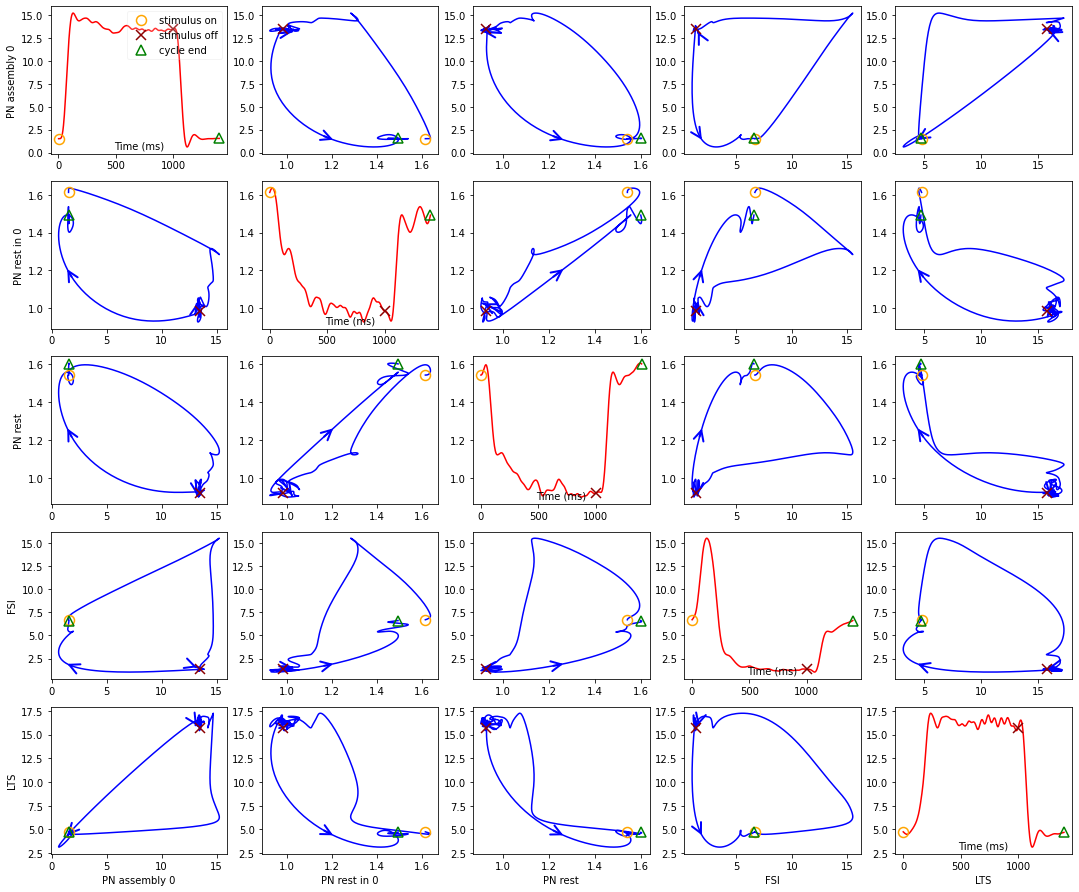

In [21]:
for i, show_assy in show_assy_ids.items():
    for j in range(show_off):
        print(('Off' if j else 'On') + f' Cycle {i:d}')
        da = PN_grp_rspk_cyc_avg[j].mean_.sel(unique_cycle=i)
        rspk = {PN_group_names[a]: da.sel(assembly=a) for a in show_assy}
        da = pop_rspk_cyc_avg[j].mean_.sel(unique_cycle=i)
        rspk.update({p: da.sel(population=p) for p in ITN_pop_names})
        axs = plot.trajectory_pairplot(rspk, time=t_cyc, **marker_kwargs)
        plt.show()

### Dispersion of population activities

In [22]:
load_from_file = True

PN_node_ids = np.concatenate([pop_ids[p] for p in PN_pop_names])

if load_from_file:
    import analysis.pipelines.population_spikes as ps
    
    ps.set_variables(RESULT_PATH=RESULT_PATH, OUTPUT_PATH=OUTPUT_PATH)
    PN_spk_file, _ = ps.get_file(TRIAL_NAME)
    if os.path.isfile(PN_spk_file): 
        with np.load(PN_spk_file) as f:
            unit_rspk = f['unit_fr']
    else:
        raise FileNotFoundError(f"Data file {PN_spk_file:s} not created")
else:
    from scipy.interpolate import interp1d

    fs_fr = 50.  # Hz. firing rate sampling frequency
    fs_ct = fs  # Hz. spike count sampling frequency
    filt_sigma = 20.0  # ms. Gaussian filer sigma

    # time bins
    time_ct_edge = np.linspace(0, 1000 * t_stop, int(t_stop * fs_ct), endpoint=False)
    time_ct = time_ct_edge + 1000 / fs_ct / 2

    time_fr = np.linspace(0, 1000 * t_stop, int(t_stop * fs_fr), endpoint=False)
    time_fr = time_fr + 1000 / fs_fr / 2
    time_fr = time_fr[(time_fr >= time_ct[0]) & (time_fr <= time_ct[-1])]

    # Unit firing rates
    unit_fr = process.unit_spike_rate_to_xarray(spikes_df, time_ct_edge,
        PN_node_ids, frequeny=True, filt_sigma=filt_sigma)
    unit_rspk = interp1d(time_ct, unit_fr, axis=1, assume_sorted=True)(time_fr)

# Assembly direction vectors of assemblies
PN_idx = pd.Series(range(len(PN_node_ids)), index=PN_node_ids)
assy_dvec = np.zeros((n_assy, PN_idx.size))
for i, ids in enumerate(Assembly_ids):
    assy_dvec[i, PN_idx[ids]] = 1
inactive_units = ~np.any(unit_rspk, axis=1)
assy_dvec[:, inactive_units] = 0  # remove inactivate units

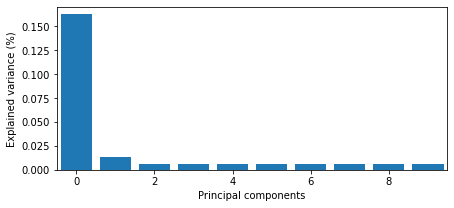

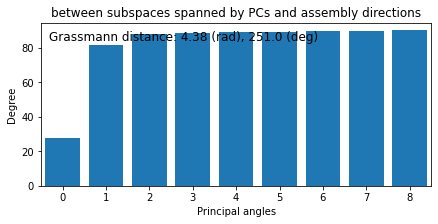

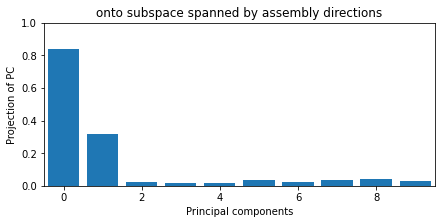

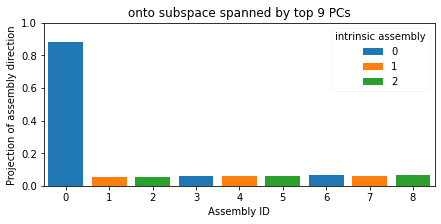

In [23]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

n_components = max(n_assy + 1, 5)
pca = PCA(n_components=n_components)
pca.fit(unit_rspk.T)

# Cosine similarity between PCs and assembly direction vectors
cosvec_mat = np.abs(cosine_similarity(pca.components_, assy_dvec))
cosvec = pd.DataFrame(cosvec_mat[:, assy_ids_disp], columns=assy_names_disp,
                      index=pd.Index(range(pca.components_.shape[0]), name='PCs'))
cosvec['max'] = cosvec.max(axis=1)
cosvec['max_assembly'] = [cosvec.columns[i] for i in np.argmax(cosvec.values, axis=1)]
cosvec['total projection'] = np.linalg.norm(cosvec_mat, axis=1)
assy2pc_proj = np.linalg.norm(cosvec_mat[:n_assy], axis=0)

P_angles, Gr_dist = metric.principal_angles(pca.components_[:n_assy], assy_dvec, rowspace=True)

# Explained variance
X = np.arange(n_components)
plt.figure(figsize=(7, 3))
plt.bar(X, pca.explained_variance_ratio_)
plt.xlim(X[[0, -1]] + np.array([-0.5, 0.5]))
plt.xticks(X)
plt.xlabel('Principal components')
plt.ylabel('Explained variance (%)')

# Distance between PC subspace and assembly subspace
X = np.arange(len(P_angles))
plt.figure(figsize=(7, 3))
plt.bar(X, 180 / np.pi * P_angles)
plt.text(0.02, 0.95, 'Grassmann distance: '
         '%.2f (rad), %.1f (deg)' % (Gr_dist, 180 / np.pi *  Gr_dist),
         transform=plt.gca().transAxes, fontsize='large',
         horizontalalignment='left', verticalalignment='top')
plt.xlim(X[[0, -1]] + np.array([-0.5, 0.5]))
plt.xticks(X)
plt.xlabel('Principal angles')
plt.ylabel('Degree')
plt.title('between subspaces spanned by PCs and assembly directions')

# Projection of PCs and assembly directions onto the each other's subspace
X = np.arange(n_components)
plt.figure(figsize=(7, 3))
plt.bar(X, cosvec['total projection'])
plt.xlim(X[[0, -1]] + np.array([-0.5, 0.5]))
plt.ylim(0, 1)
plt.xticks(X)
plt.xlabel('Principal components')
plt.ylabel('Projection of PC')
plt.title('onto subspace spanned by assembly directions')

X = np.arange(n_assy)
plt.figure(figsize=(7, 3))
if isdivision:
    for i, ids in assy_div.items():
        plt.bar(ids, assy2pc_proj[ids], label=str(i))
    plt.legend(title='intrinsic assembly', loc='upper right', framealpha=0.2)
else:
    plt.bar(X, assy2pc_proj)
plt.xlim(X[[0, -1]] + np.array([-0.5, 0.5]))
plt.ylim(0, 1)
plt.xticks(X)
plt.xlabel('Assembly ID')
plt.ylabel('Projection of assembly direction')
plt.title(f'onto subspace spanned by top {n_assy:d} PCs')

plt.show()

In [24]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

assy_names_radar = assy_names_disp + [assy_names_disp[0]]
PC_names_radar = [f'PC {i:d}' for i in range(n_components)]
PC_names_radar = PC_names_radar + [PC_names_radar[0]]
PC_idx_radar = list(range(n_components)) + [0]
cmap = px.colors.sample_colorscale('thermal', np.linspace(0, 1, n_components))[::-1]
if isdivision:
    cmap2 = px.colors.sample_colorscale('Rainbow', np.linspace(0, 1, \
        max(len(ids) for ids in assy_div.values())))[::-1]
else:
    cmap2 = px.colors.sample_colorscale('Rainbow', np.linspace(0, 1, n_assy))[::-1]
rotation = 130 if isdivision else 90
maxcos = cosvec[assy_names_disp].values.max()

fig = go.Figure()
for i in range(n_components)[::-1]:
    fig.add_trace(go.Scatterpolar(
        name=PC_names_radar[i], r=cosvec.loc[i, assy_names_radar],
        theta=assy_names_radar, mode='lines', line_color=cmap[i]
    ))
fig.update_polars(
    gridshape = 'linear',
    angularaxis = dict(rotation=rotation, direction="clockwise"),
    radialaxis = dict(angle=90, tickangle=90, nticks=4, range=(0, maxcos))
)
fig.update_layout(
    width=600, height=400, margin=dict(l=10, r=100, t=60, b=20),
    title = dict(text='Cosine similarity between PCs and assembly directions', x=0.5),
    legend = dict(traceorder='reversed', xanchor='left', x=1.0, y=0.5)
)
fig.show()

if isdivision:
    n_int_assy = len(assy_div)
    fig = make_subplots(
        rows=1, cols=n_int_assy, specs=[[{'type': 'polar'}] * n_int_assy],
        subplot_titles=[f'intrinsic assembly {a:d}' for a in assy_div],
        horizontal_spacing=0.0
    )
    for i, ids in enumerate(assy_div.values()):
        for j in range(len(ids)):
            fig.add_trace(go.Scatterpolar(name=assy_names[ids[j]],
                r=cosvec.loc[PC_idx_radar, assy_names[ids[j]]],
                theta=PC_names_radar, mode='lines', line_color=cmap2[j],
                legendgroup=i, legendgrouptitle_text=f'intrinsic assembly {i:d}'
            ), row=1, col=i + 1)
    fig.update_layout(width=1200, height=360, margin=dict(l=10, r=120, t=50, b=30))
    for annotation in fig['layout']['annotations']: 
        annotation['y'] = 1.08
else:
    fig = go.Figure()
    for i in range(n_assy):
        fig.add_trace(go.Scatterpolar(name=assy_names_disp[i],
            r=cosvec.loc[PC_idx_radar, assy_names_disp[i]],
            theta=PC_names_radar, mode='lines', line_color=cmap2[i]
        ))
    fig.update_layout(width=600, height=400, margin=dict(l=10, r=100, t=40, b=40))
fig.update_polars(
    gridshape = 'linear',
    angularaxis = dict(rotation=90, direction="clockwise"),
    radialaxis = dict(angle=90, tickangle=90, nticks=4, range=(0, maxcos))
)
fig.update_layout(legend=dict(xanchor='left', x=1.0, y=0.5))
fig.show()

print("Alignment (cosine similarity) between PCs and assembly directions")
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(cosvec)

Alignment (cosine similarity) between PCs and assembly directions


,assembly 0,assembly 3,assembly 6,assembly 1,assembly 4,assembly 7,assembly 2,assembly 5,assembly 8,max,max_assembly,total projection
PCs,,,,,,,,,,,,
0,0.832,0.030,0.031,0.037,0.043,0.041,0.039,0.041,0.040,0.832,assembly 0,0.839
1,0.295,0.044,0.053,0.029,0.029,0.039,0.037,0.035,0.044,0.295,assembly 0,0.316
2,0.016,0.003,0.004,0.000,0.012,0.006,0.003,0.001,0.007,0.016,assembly 0,0.023
3,0.004,0.001,0.005,0.007,0.002,0.008,0.004,0.005,0.007,0.008,assembly 7,0.016
4,0.004,0.005,0.011,0.006,0.010,0.004,0.007,0.003,0.002,0.011,assembly 6,0.019
5,0.010,0.010,0.008,0.001,0.021,0.003,0.001,0.009,0.016,0.021,assembly 4,0.033
6,0.011,0.017,0.003,0.002,0.007,0.011,0.002,0.007,0.003,0.017,assembly 3,0.026
7,0.022,0.010,0.007,0.008,0.001,0.018,0.005,0.009,0.012,0.022,assembly 0,0.036
8,0.017,0.004,0.002,0.018,0.014,0.012,0.013,0.010,0.023,0.023,assembly 8,0.042
